# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:10, 17.6MB/s]                              
SVHN Testing Set: 64.3MB [00:04, 15.8MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

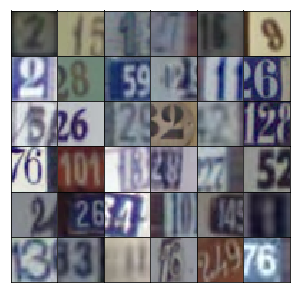

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [19]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [20]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 4.1307... Generator Loss: 0.0224
Epoch 1/25... Discriminator Loss: 1.6267... Generator Loss: 0.8670
Epoch 1/25... Discriminator Loss: 0.3879... Generator Loss: 1.8902
Epoch 1/25... Discriminator Loss: 0.4453... Generator Loss: 1.2125
Epoch 1/25... Discriminator Loss: 0.3074... Generator Loss: 1.7394
Epoch 1/25... Discriminator Loss: 0.3502... Generator Loss: 1.2197
Epoch 1/25... Discriminator Loss: 0.0453... Generator Loss: 3.1306
Epoch 1/25... Discriminator Loss: 0.0189... Generator Loss: 4.0028
Epoch 1/25... Discriminator Loss: 0.0112... Generator Loss: 4.5209
Epoch 1/25... Discriminator Loss: 0.0076... Generator Loss: 4.9243


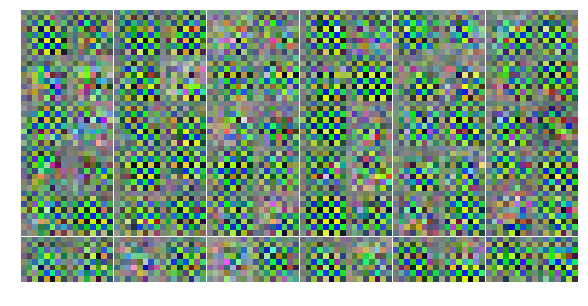

Epoch 1/25... Discriminator Loss: 0.0054... Generator Loss: 5.2347
Epoch 1/25... Discriminator Loss: 0.0042... Generator Loss: 5.4966
Epoch 1/25... Discriminator Loss: 0.0034... Generator Loss: 5.7097
Epoch 1/25... Discriminator Loss: 0.0028... Generator Loss: 5.9006
Epoch 1/25... Discriminator Loss: 0.0024... Generator Loss: 6.0669
Epoch 1/25... Discriminator Loss: 0.0020... Generator Loss: 6.2218
Epoch 1/25... Discriminator Loss: 0.0018... Generator Loss: 6.3606
Epoch 1/25... Discriminator Loss: 0.0016... Generator Loss: 6.4884
Epoch 1/25... Discriminator Loss: 0.0014... Generator Loss: 6.6134
Epoch 1/25... Discriminator Loss: 0.0012... Generator Loss: 6.7146


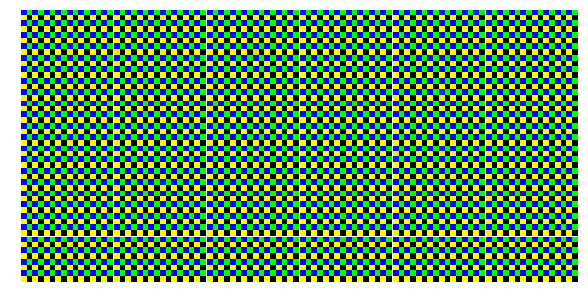

Epoch 1/25... Discriminator Loss: 0.0011... Generator Loss: 6.8343
Epoch 1/25... Discriminator Loss: 0.0010... Generator Loss: 6.9229
Epoch 1/25... Discriminator Loss: 0.0009... Generator Loss: 7.0220
Epoch 1/25... Discriminator Loss: 0.0008... Generator Loss: 7.1056
Epoch 1/25... Discriminator Loss: 0.0008... Generator Loss: 7.1939
Epoch 1/25... Discriminator Loss: 0.0007... Generator Loss: 7.2603
Epoch 1/25... Discriminator Loss: 0.0007... Generator Loss: 7.3404
Epoch 1/25... Discriminator Loss: 0.0006... Generator Loss: 7.4210
Epoch 1/25... Discriminator Loss: 0.0006... Generator Loss: 7.4871
Epoch 1/25... Discriminator Loss: 0.0005... Generator Loss: 7.5613


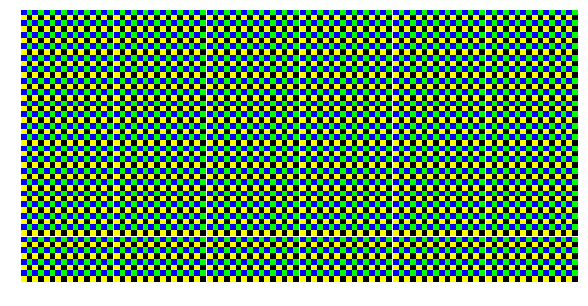

Epoch 1/25... Discriminator Loss: 0.0005... Generator Loss: 7.6073
Epoch 1/25... Discriminator Loss: 0.0005... Generator Loss: 7.6748
Epoch 1/25... Discriminator Loss: 0.0004... Generator Loss: 7.7454
Epoch 1/25... Discriminator Loss: 0.0004... Generator Loss: 7.7954
Epoch 1/25... Discriminator Loss: 0.0004... Generator Loss: 7.8447
Epoch 1/25... Discriminator Loss: 0.0004... Generator Loss: 7.9104
Epoch 1/25... Discriminator Loss: 0.0004... Generator Loss: 7.9625
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.1192
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.0580
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.1135


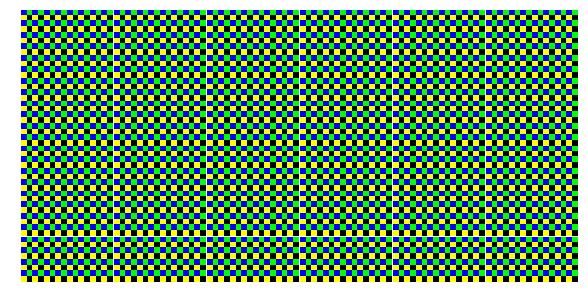

Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.1576
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.1932
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.2457
Epoch 1/25... Discriminator Loss: 0.0003... Generator Loss: 8.2972
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.3368
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.3811
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.4178
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.4580
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.4992
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.5374


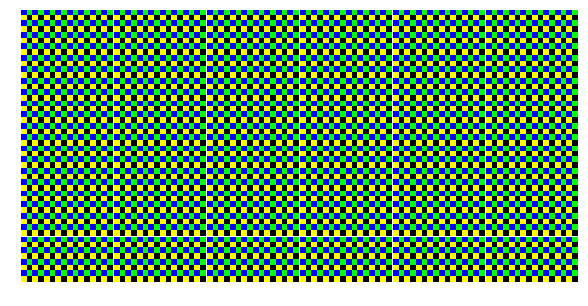

Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.5682
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.6122
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.6500
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.6845
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.7147
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.7512
Epoch 1/25... Discriminator Loss: 0.0002... Generator Loss: 8.7825
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 8.8165
Epoch 2/25... Discriminator Loss: 0.0002... Generator Loss: 8.8479
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 8.8789


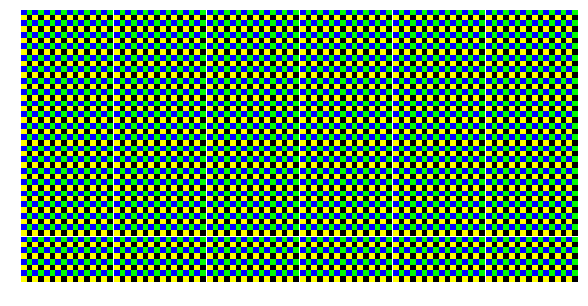

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 8.9120
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 8.9379
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 8.9658
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 8.9977
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.0288
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.0523
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.0887
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.1066
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.1662
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.1689


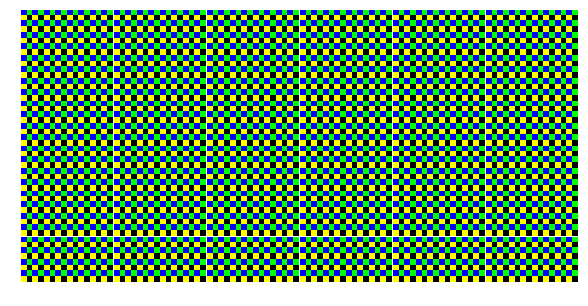

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.1952
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.2207
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.2367
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.2671
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.3000
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.3537
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.3486
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.3732
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4085
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4124


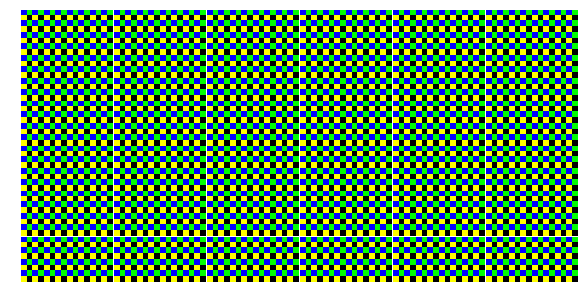

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4407
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4527
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4859
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.4988
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.5295
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.5521
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.5746
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.5707
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.6168
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.6264


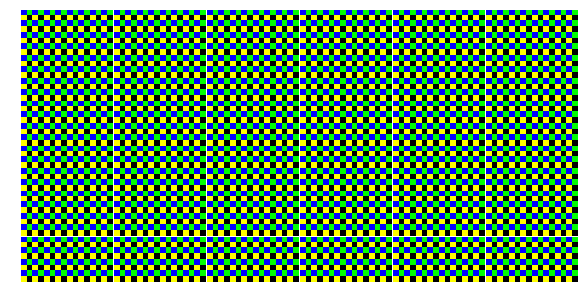

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7018
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.6830
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7074
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7229
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7240
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7658
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.7837
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8053
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8164
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8418


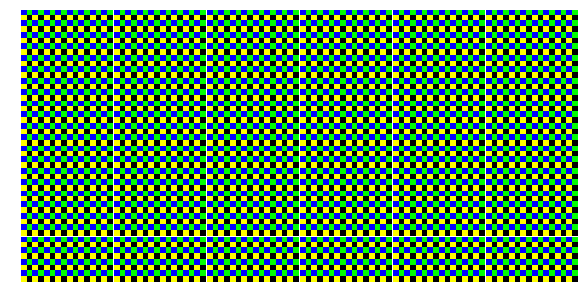

Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8622
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8611
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.8995
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.9167
Epoch 2/25... Discriminator Loss: 0.0001... Generator Loss: 9.9370
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 9.9493
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 9.9715
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 9.9866
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.0065
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.1809


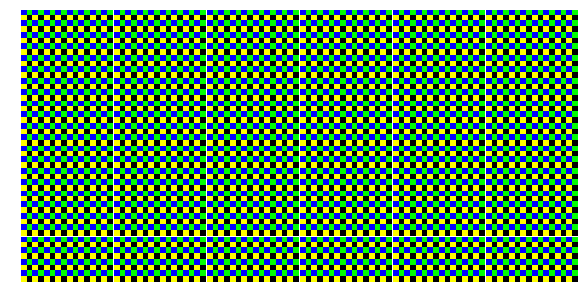

Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.0353
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.0590
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.0746
Epoch 2/25... Discriminator Loss: 0.0000... Generator Loss: 10.0939
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1087
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1530
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1250
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1588
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1761
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.1908


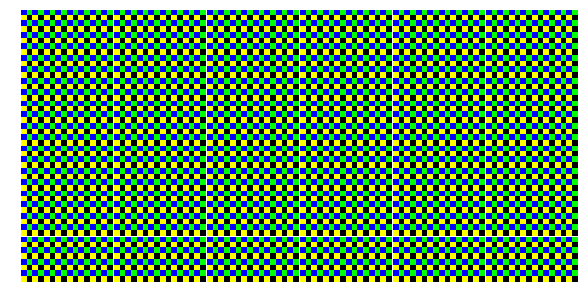

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2067
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2239
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2409
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2561
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2724
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2870
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.2978
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3173
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3321
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3479


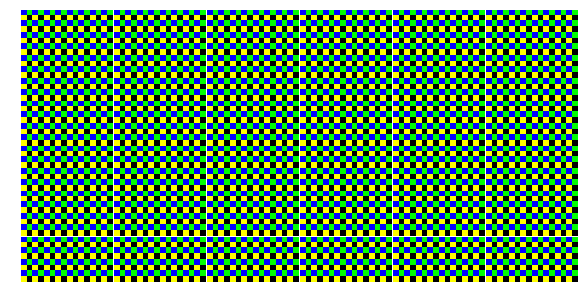

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3616
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3694
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.3919
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4067
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4200
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4351
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4506
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4645
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4794
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.4933


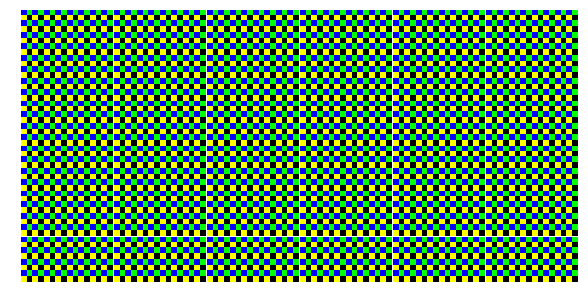

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5075
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5205
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5312
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5481
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5624
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5744
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.5888
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6022
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6090
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6261


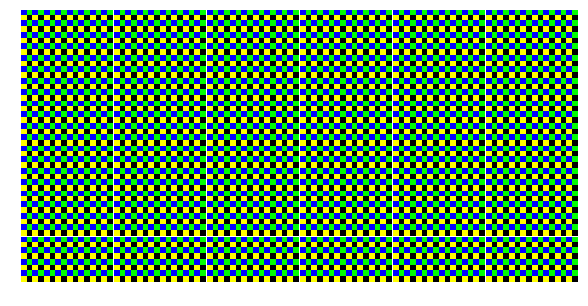

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6412
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6541
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6689
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6657
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.6926
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7050
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7203
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7316
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7419
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7559


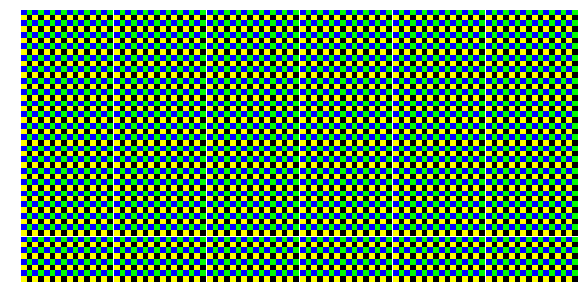

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7717
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7832
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.7881
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8087
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8196
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8269
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8452
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8574
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8701
Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8793


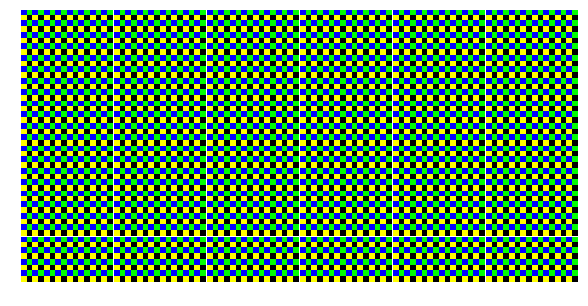

Epoch 3/25... Discriminator Loss: 0.0000... Generator Loss: 10.8929
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9060
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9169
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9319
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9370
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9457
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9523
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9720
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 10.9877
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0280


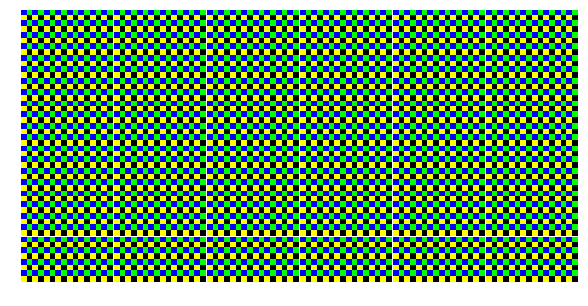

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0004
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0200
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0318
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0437
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0535
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0599
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0692
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0882
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.0981
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1096


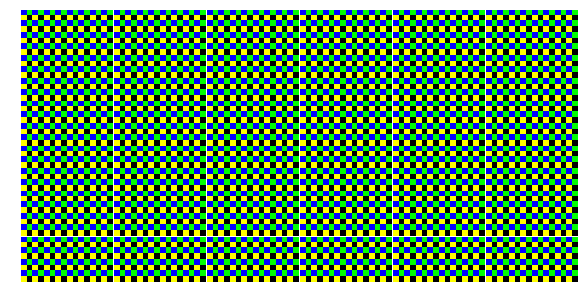

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1200
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1313
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1419
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1484
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1374
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2075
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1831
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1956
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.1955
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2170


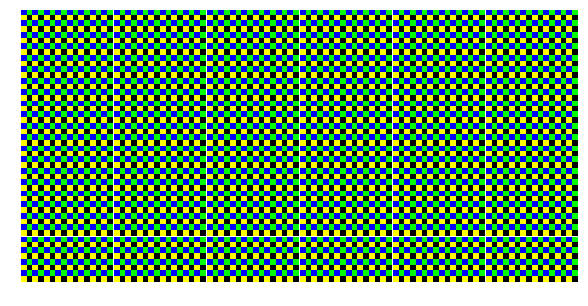

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2271
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2587
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2479
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2505
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2681
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2896
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2905
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.2966
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3082
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3125


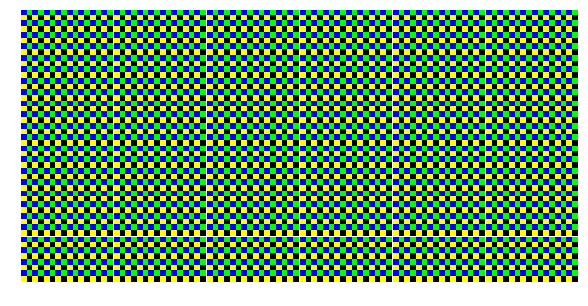

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3297
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3351
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3470
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3482
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3687
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3723
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3856
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.3973
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4069
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4173


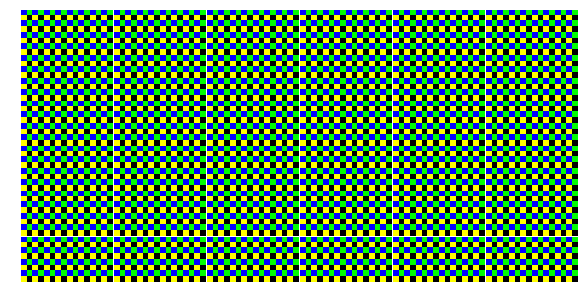

Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4256
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4376
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4472
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4544
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4707
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4782
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4861
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.4960
Epoch 4/25... Discriminator Loss: 0.0000... Generator Loss: 11.5062
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5163


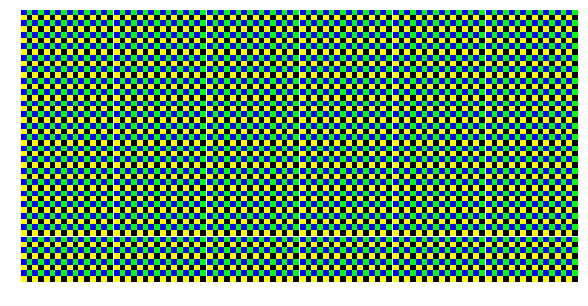

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5209
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5343
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5437
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5511
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5621
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5712
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5683
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5770
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5947
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.5879


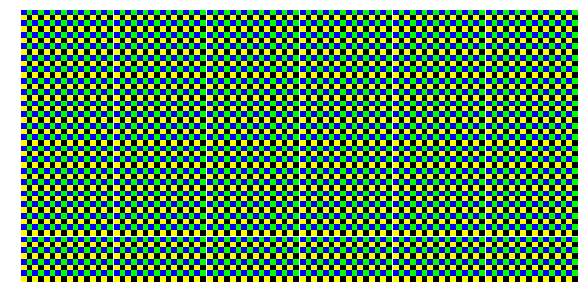

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6163
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6182
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6287
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6379
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6434
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6539
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6701
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6788
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6907
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.6985


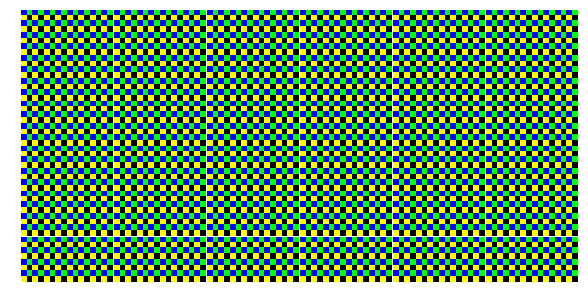

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7036
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7168
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7255
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7346
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7428
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7518
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7606
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7683
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7774
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7854


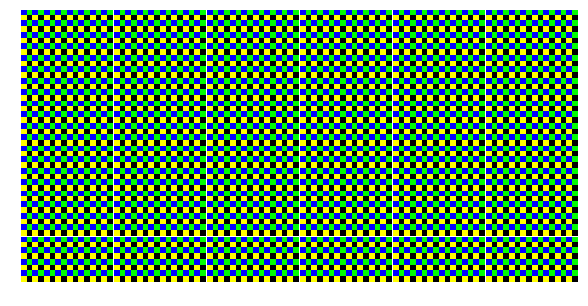

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.7933
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8042
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8128
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8213
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8298
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8387
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8464
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8552
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8643
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8727


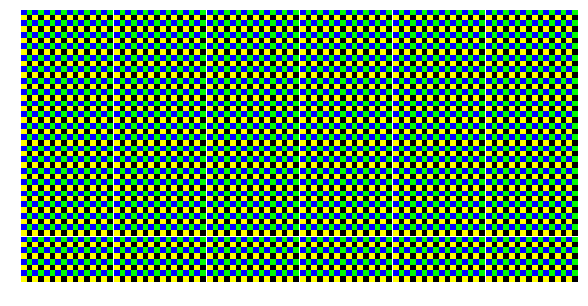

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8860
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8888
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.8973
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9065
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9922
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9237
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9317
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9391
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9488
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9505


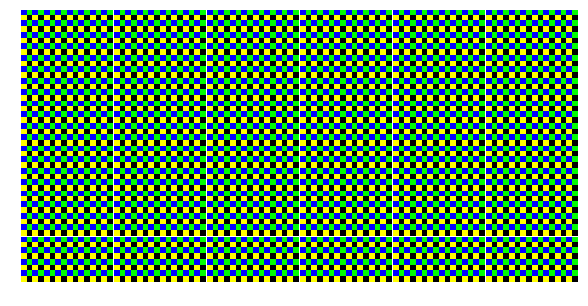

Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9583
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9733
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9785
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9866
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 11.9963
Epoch 5/25... Discriminator Loss: 0.0000... Generator Loss: 12.0048
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0122
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0228
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0231
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0762


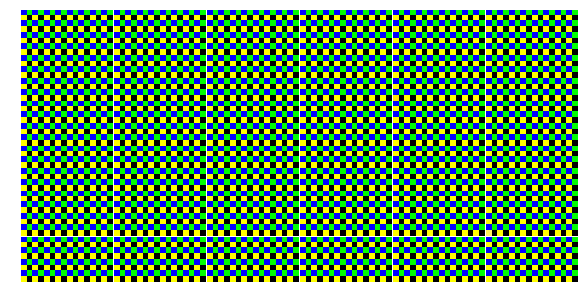

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2038
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0556
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0630
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0711
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0741
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.0876
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1472
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1033
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1113
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1190


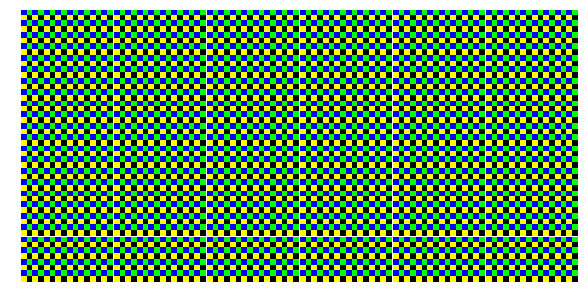

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1241
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1345
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1419
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1506
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1580
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1660
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1742
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1820
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1847
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.1970


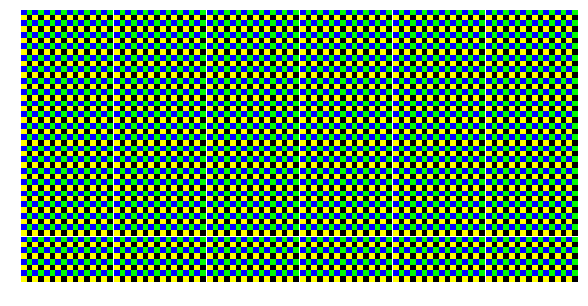

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2027
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2129
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2193
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2284
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2338
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2437
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2506
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2582
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2663
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2737


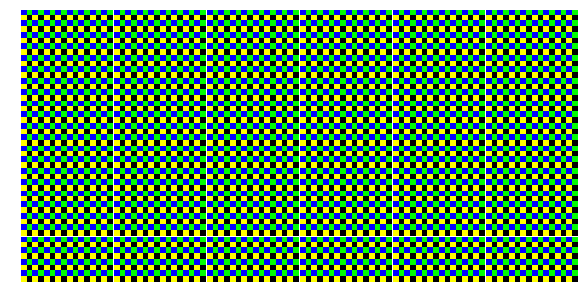

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2822
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2798
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.2933
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3049
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3108
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3182
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3273
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3351
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3427
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3499


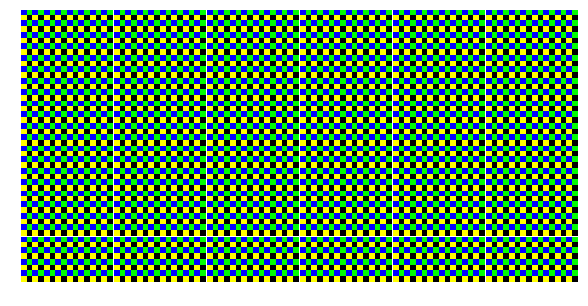

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3570
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3632
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3730
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3756
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3878
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.3948
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4025
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4099
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4169
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4246


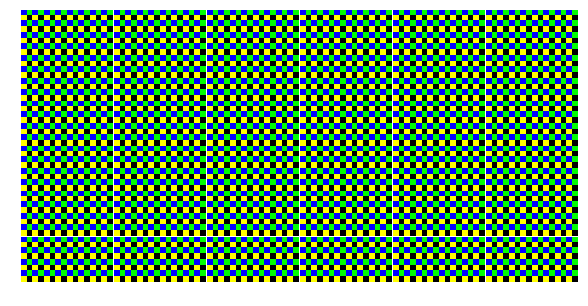

Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4312
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4395
Epoch 6/25... Discriminator Loss: 0.0000... Generator Loss: 12.4470
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4525
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4614
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4689
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4758
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4835
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4906
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.4980


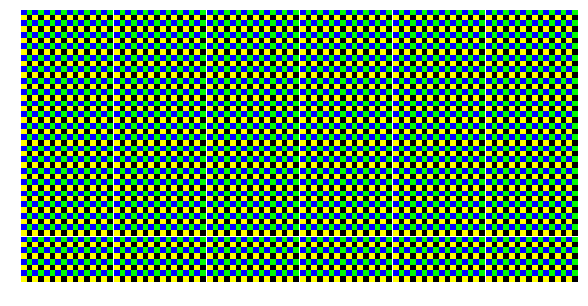

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5050
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5119
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5191
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5330
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5338
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5415
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5481
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5553
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5626
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5693


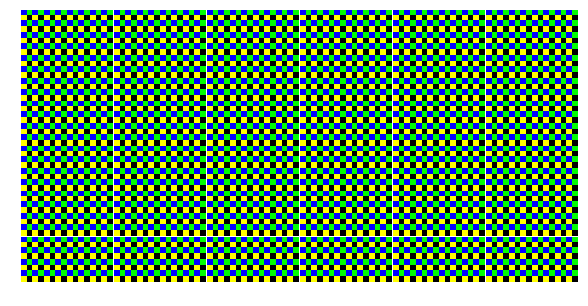

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5764
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5840
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5912
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.5944
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6051
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6127
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6192
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6265
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6339
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6411


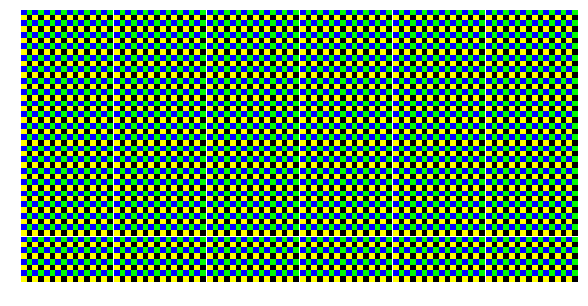

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6477
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6544
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6616
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6678
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6750
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7179
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6851
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.6965
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7033
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7104


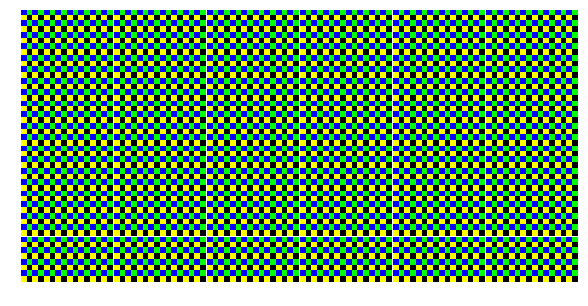

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7174
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7401
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7312
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7380
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7420
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7518
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7586
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7653
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7740
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7795


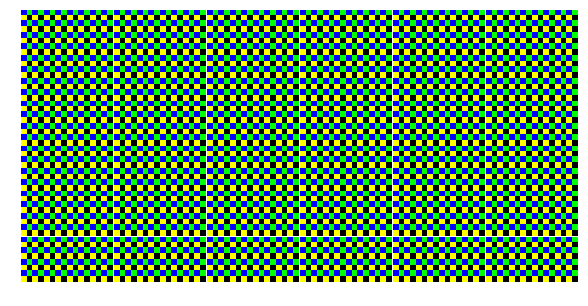

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7868
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.7935
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8001
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8067
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8142
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8209
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8277
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8345
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8414
Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8483


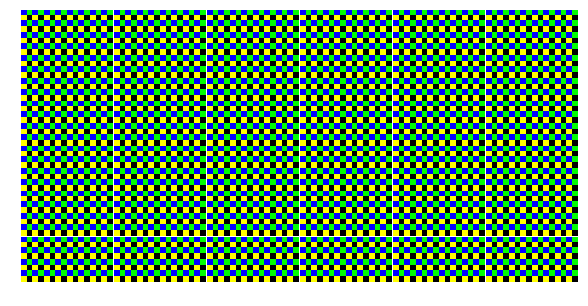

Epoch 7/25... Discriminator Loss: 0.0000... Generator Loss: 12.8552
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8616
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8685
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8752
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8819
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8886
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.8953
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9023
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9091
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9157


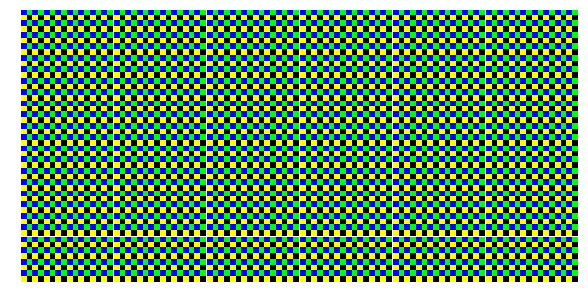

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9224
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9290
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9357
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9421
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9489
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9557
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9622
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9686
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9753
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9820


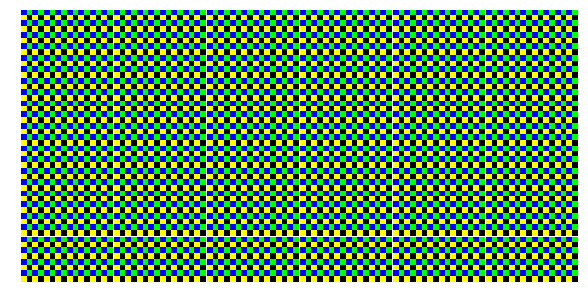

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9887
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 12.9954
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0020
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0086
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0151
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0217
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0283
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0349
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0414
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0479


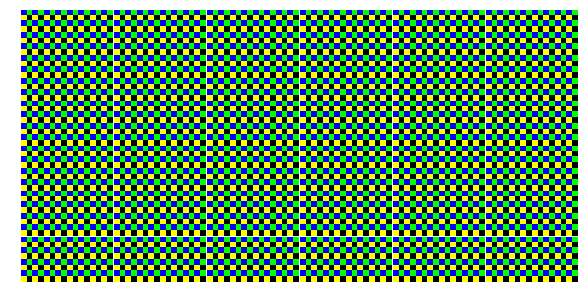

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0545
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0498
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0673
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0739
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0806
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0871
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0936
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.0994
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1065
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1131


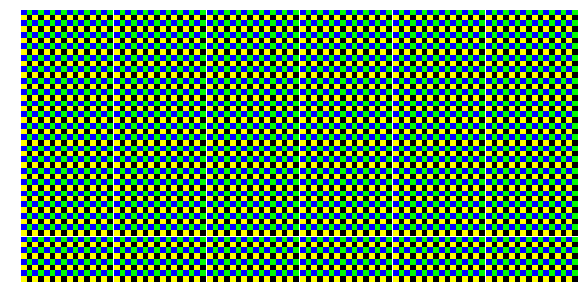

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1195
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1259
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1325
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1389
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1455
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1521
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1553
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1541
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1718
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1782


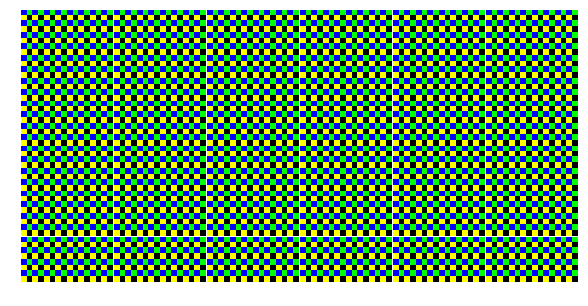

Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1846
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1910
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.1974
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.2039
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.2098
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.2168
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.2234
Epoch 8/25... Discriminator Loss: 0.0000... Generator Loss: 13.2297
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2358
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2423


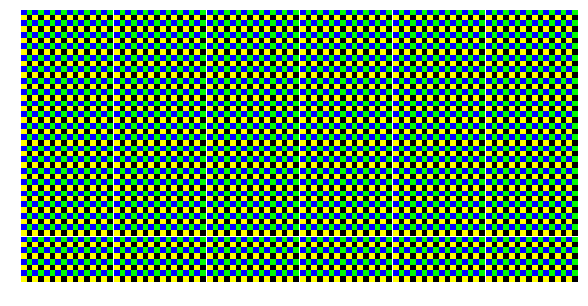

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2487
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2551
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2617
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2677
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2744
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2806
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2870
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2934
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.2995
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3060


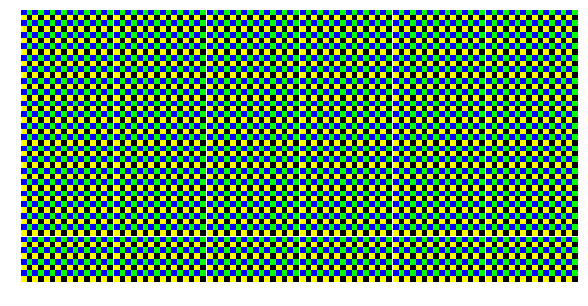

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3120
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3184
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3250
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3311
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3374
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3435
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3498
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3562
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3624
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3689


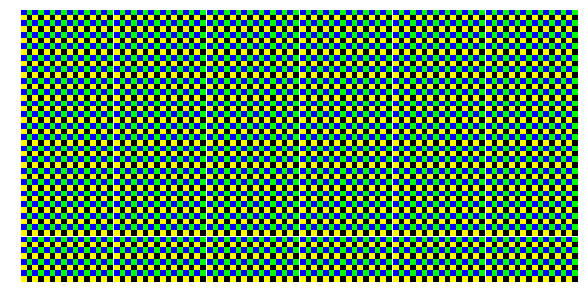

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3750
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3813
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3875
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.3938
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4001
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4064
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4125
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4186
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4248
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4310


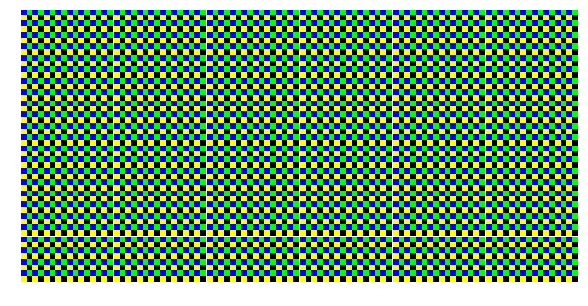

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4371
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4434
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4497
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4559
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4622
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4683
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4744
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4806
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4866
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4930


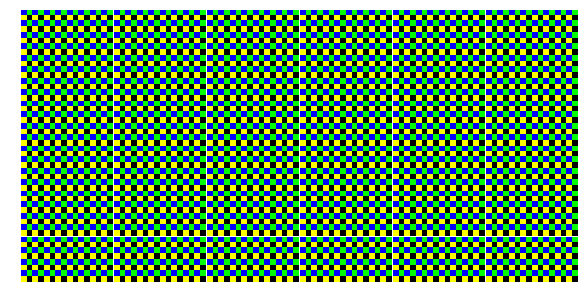

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.4988
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5053
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5116
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5179
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5243
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5305
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5367
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5428
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5490
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5545


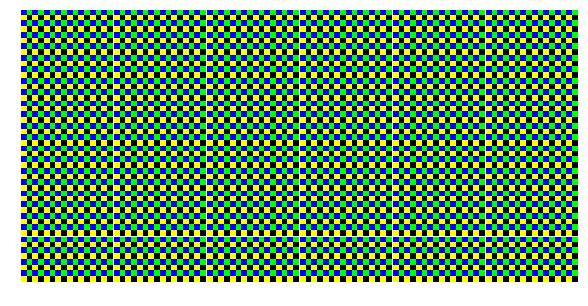

Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5612
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5674
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5735
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5798
Epoch 9/25... Discriminator Loss: 0.0000... Generator Loss: 13.5855
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.5901
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.5980
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6041
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6102
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6164


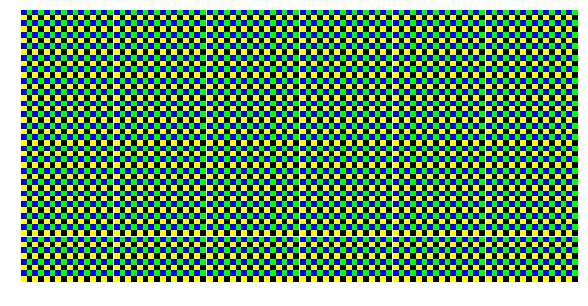

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6223
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6282
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6348
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6408
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6469
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6528
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6577
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6650
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6710
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6752


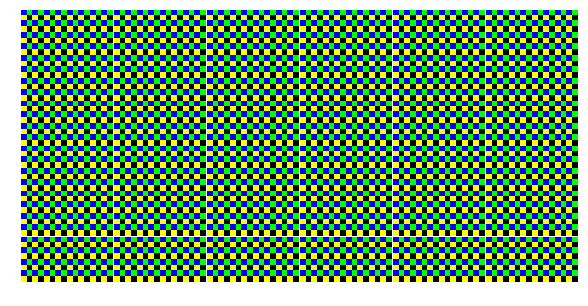

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6832
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6891
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.6949
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7012
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7069
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7133
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7194
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7255
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7313
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7373


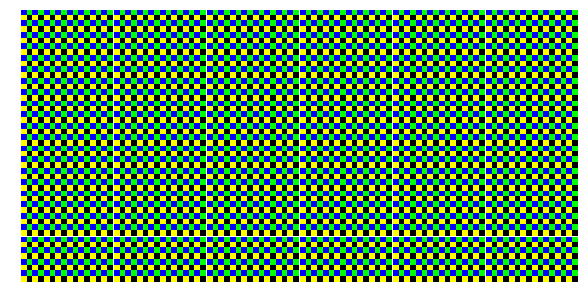

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7435
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7481
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7555
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7612
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7674
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7733
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7785
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7851
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7912
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.7935


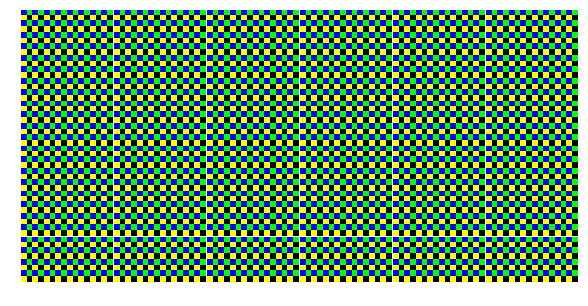

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8032
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8092
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8149
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8210
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8270
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8330
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8389
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8449
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8509
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9274


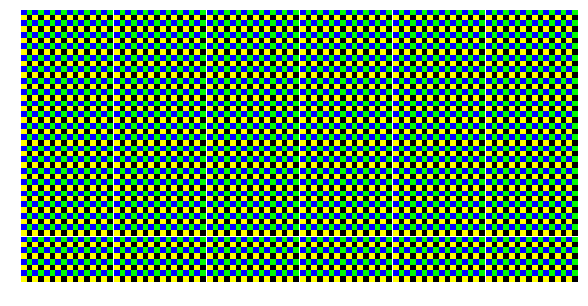

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8630
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8690
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8751
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8811
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8870
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8930
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.8989
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9048
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9107
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9168


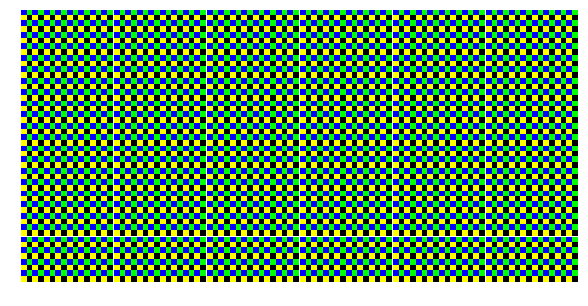

Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9229
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9287
Epoch 10/25... Discriminator Loss: 0.0000... Generator Loss: 13.9346
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9404
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9464
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9523
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9582
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9640
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9699
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9760


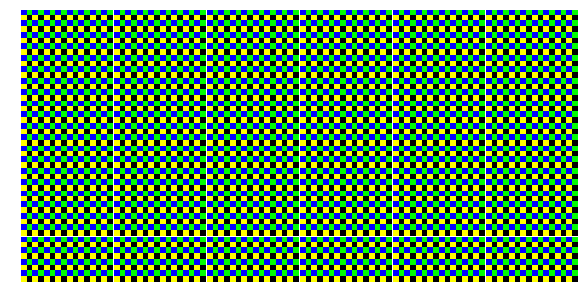

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9754
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9878
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9937
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 13.9996
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0054
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0112
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0170
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0231
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0286
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0345


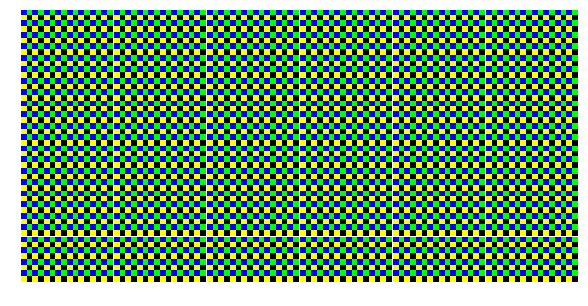

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1282
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0463
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0522
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0581
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0640
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0698
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0756
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0814
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0872
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0932


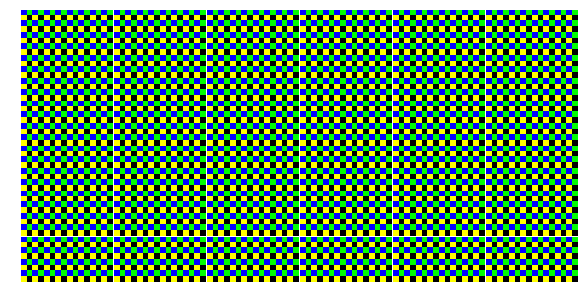

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.0991
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1047
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1106
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1164
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1221
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1279
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1339
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1385
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1455
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1513


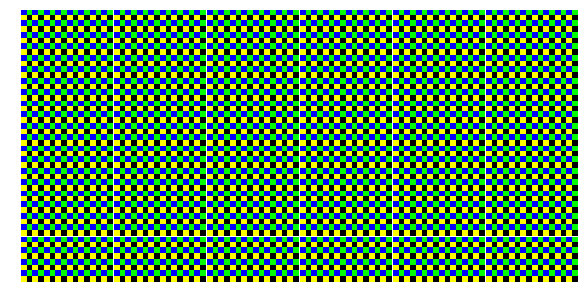

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1570
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1629
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1687
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1745
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1803
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1861
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1920
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.1979
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2038
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2098


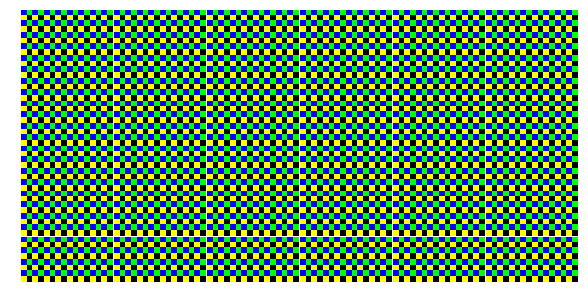

Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2156
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2213
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2272
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2330
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2387
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2445
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2504
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2563
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2621
Epoch 11/25... Discriminator Loss: 0.0000... Generator Loss: 14.2678


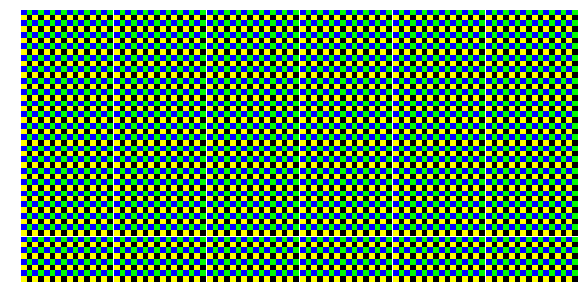

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.2734
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.2792
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.2850
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.2908
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.2965
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3023
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3082
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3139
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3197
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3255


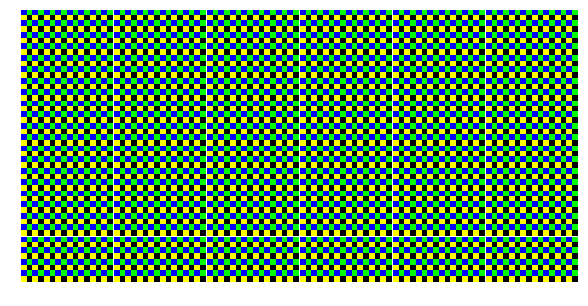

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3312
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3369
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3424
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3483
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3541
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3598
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3634
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3710
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3769
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3825


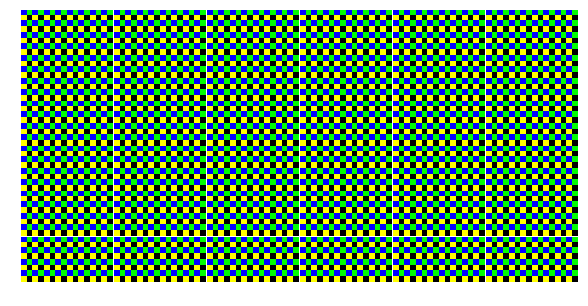

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3885
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3943
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.3998
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4056
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4113
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4170
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4228
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4285
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4341
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4397


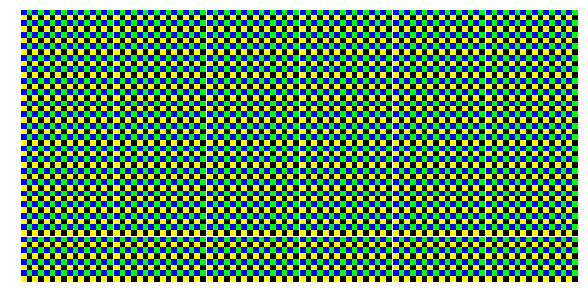

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4454
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4510
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4567
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4626
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4683
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4739
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4797
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4853
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4911
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.4967


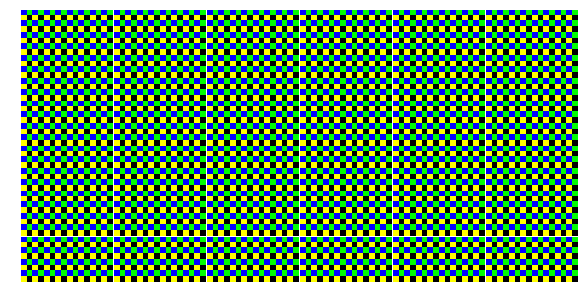

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5024
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5081
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5138
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5195
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5253
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5311
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5368
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5427
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5484
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5530


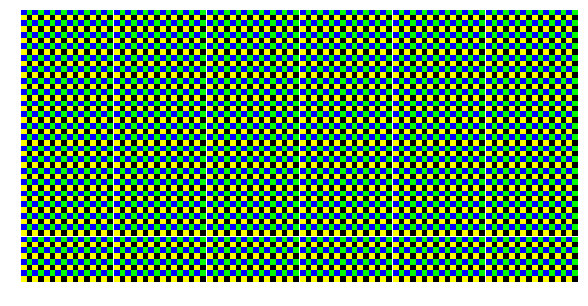

Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5597
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5654
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5710
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5768
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5821
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5883
Epoch 12/25... Discriminator Loss: 0.0000... Generator Loss: 14.5939
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.5993
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6040
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6107


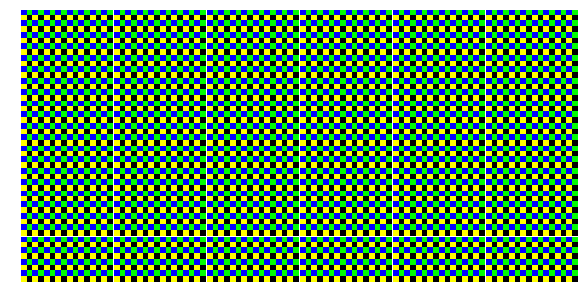

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6164
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6221
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6276
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6335
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6391
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6447
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6506
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6561
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6618
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6666


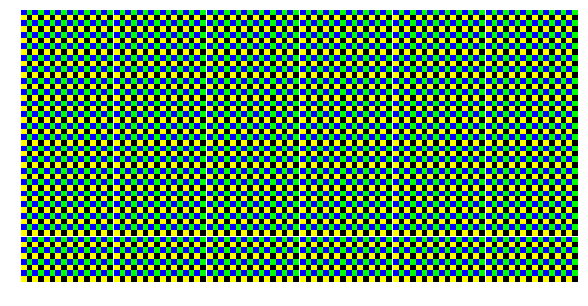

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6728
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6786
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6841
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6897
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6953
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.6997
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7066
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7123
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7180
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7236


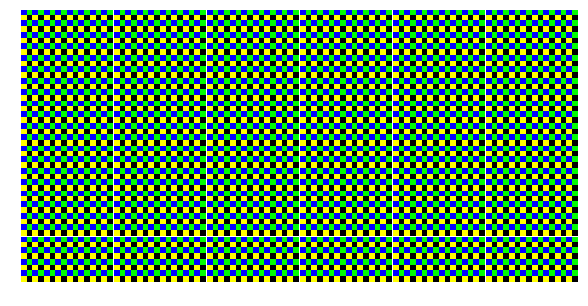

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7292
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7348
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7405
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7461
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7517
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7573
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7628
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7684
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7739
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7795


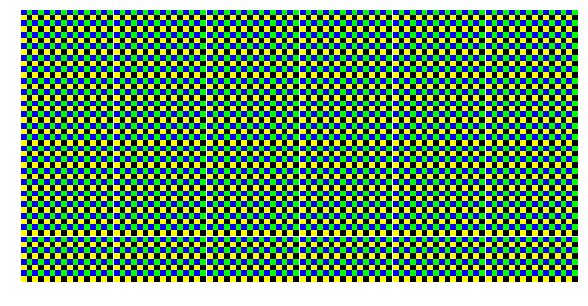

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7852
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7909
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.7965
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8021
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8076
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8132
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8188
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8245
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8300
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8357


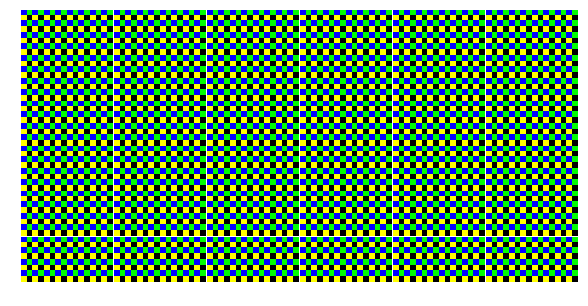

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8412
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8470
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8527
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8584
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8641
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8697
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8753
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8809
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8850
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.8920


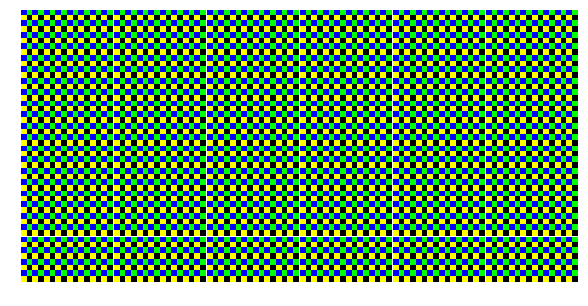

Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.9217
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.9033
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.9090
Epoch 13/25... Discriminator Loss: 0.0000... Generator Loss: 14.9129
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9198
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9251
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9311
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9365
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9421
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9476


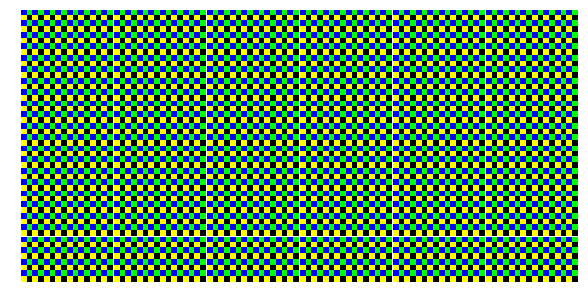

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9535
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9584
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1298
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0450
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1083
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9814
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9869
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9922
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 14.9979
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0036


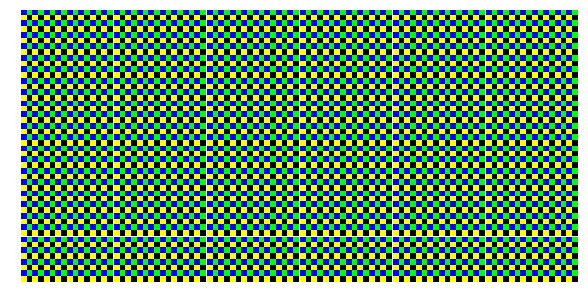

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0091
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0144
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0200
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0256
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0313
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0368
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0425
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0479
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0534
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0591


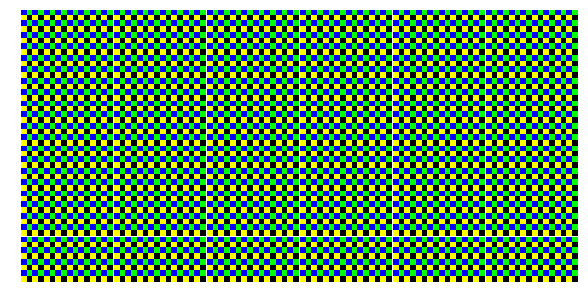

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0646
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0702
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0758
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0812
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0866
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0922
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.0976
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1032
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1088
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1143


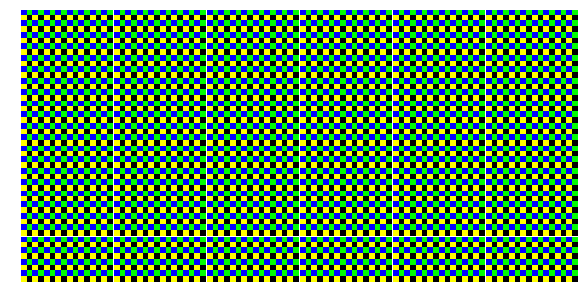

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1199
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1254
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1308
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1364
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1419
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1475
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1531
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1586
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1642
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1698


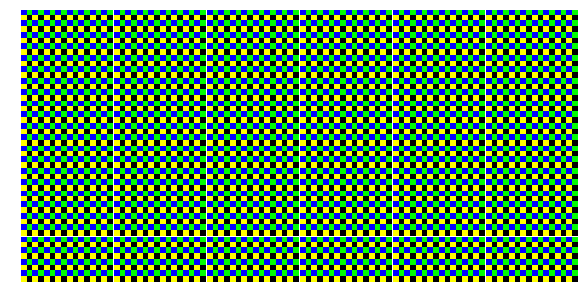

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1754
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1812
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1868
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1923
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.1979
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2032
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2088
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2143
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2200
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2256


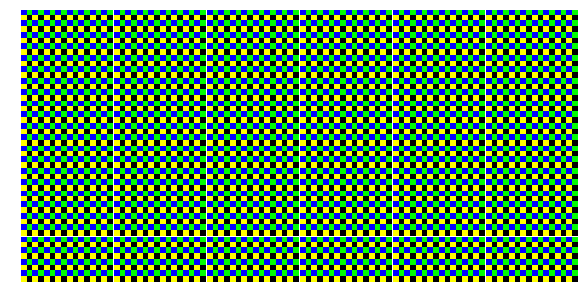

Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2312
Epoch 14/25... Discriminator Loss: 0.0000... Generator Loss: 15.2366
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2411
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2471
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4895
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2583
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2639
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2693
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2750
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2805


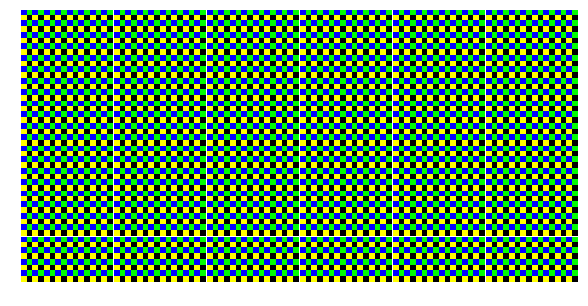

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2860
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2916
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.2971
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3026
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3079
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3134
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3191
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3246
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3298
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3353


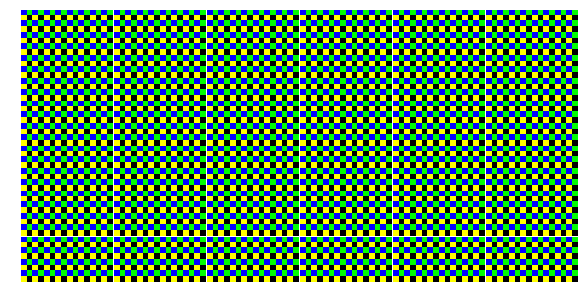

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3409
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3464
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3520
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3576
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3630
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3684
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3740
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3794
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3850
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.3905


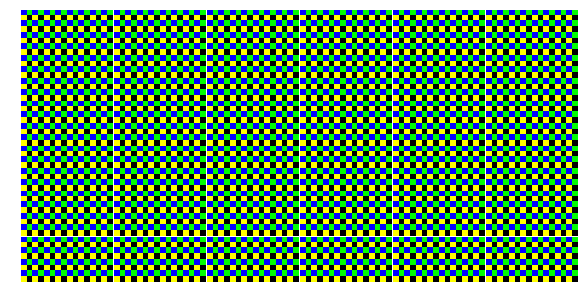

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4029
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4013
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4068
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4121
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4176
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4233
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4287
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4343
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4398
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4452


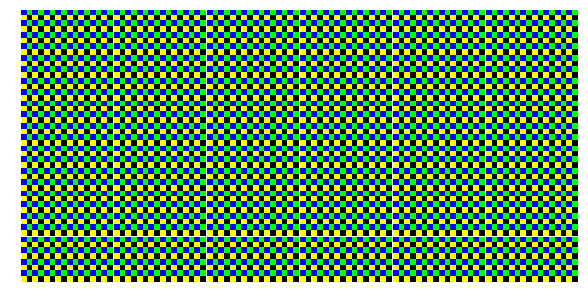

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4506
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4561
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4617
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4672
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4726
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4781
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4837
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4892
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.4949
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5005


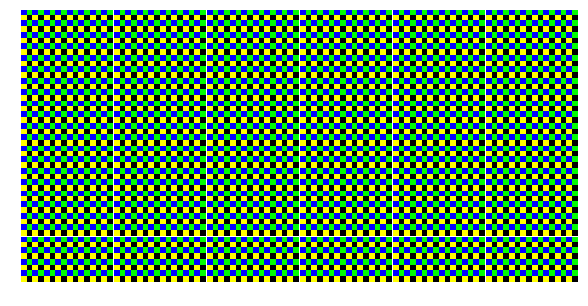

Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5059
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5114
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5169
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5223
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5277
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5334
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5388
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5445
Epoch 15/25... Discriminator Loss: 0.0000... Generator Loss: 15.5499
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5552


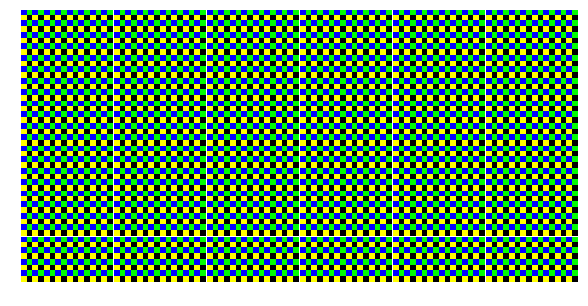

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5606
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5661
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5716
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5772
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5825
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5881
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5936
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.5991
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6046
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6100


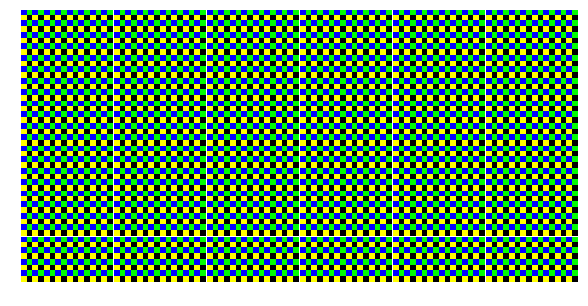

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6155
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6208
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6262
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6318
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6372
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6425
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6479
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6535
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6590
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6645


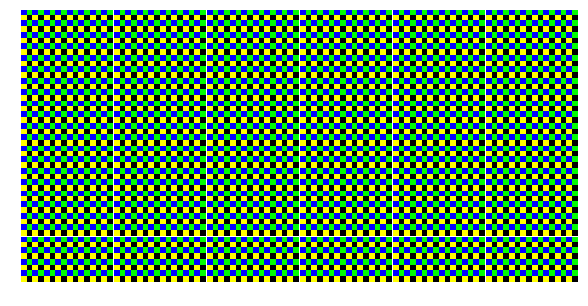

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6700
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6754
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6808
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6863
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6918
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.6972
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7027
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7081
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7134
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7188


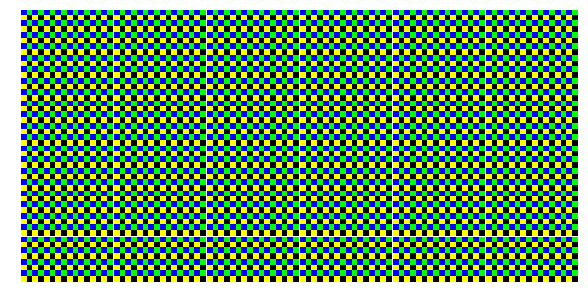

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7242
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7296
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7352
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7408
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7461
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7516
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7569
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7623
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7677
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7733


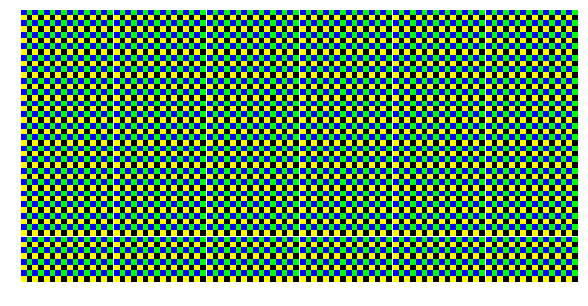

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7787
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7842
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7896
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.7909
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8007
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8063
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8118
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8173
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8227
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8282


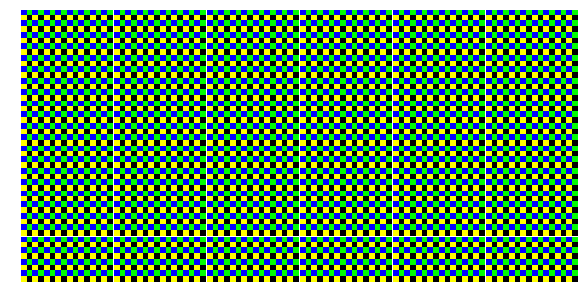

Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8336
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8390
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8445
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8500
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8556
Epoch 16/25... Discriminator Loss: 0.0000... Generator Loss: 15.8609
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8662
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8716
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8771
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8826


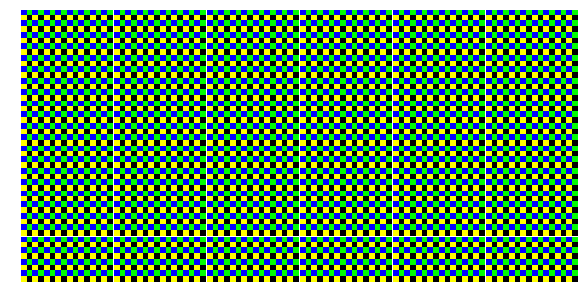

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8880
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8933
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.8989
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9043
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9098
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9152
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9206
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9261
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9315
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9367


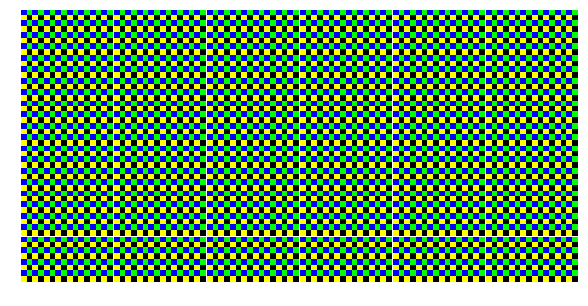

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9422
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9477
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9530
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9583
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9637
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9692
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9748
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9803
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9857
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9910


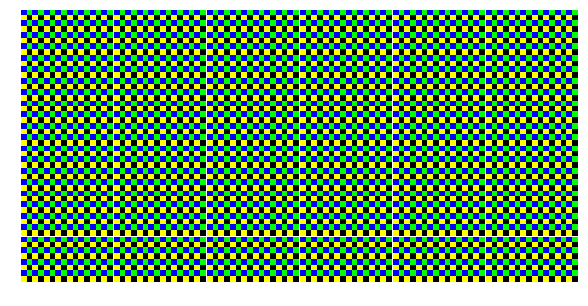

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 15.9964
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0019
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0073
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0127
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0181
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0235
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0288
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0343
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0395
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0450


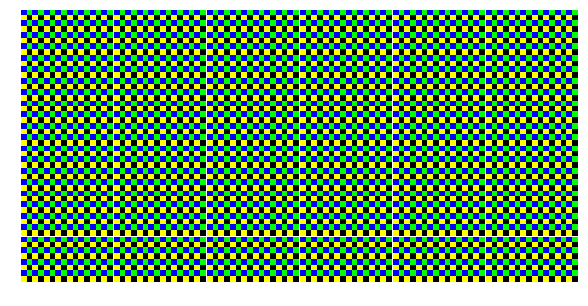

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0505
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0558
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0613
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0667
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0720
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0775
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0829
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0883
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0938
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.0991


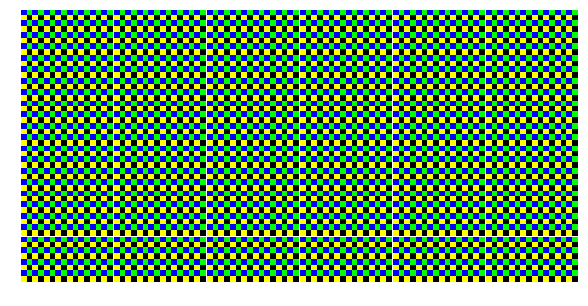

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1047
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1102
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1156
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1213
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1268
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1321
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1376
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1429
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1482
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1537


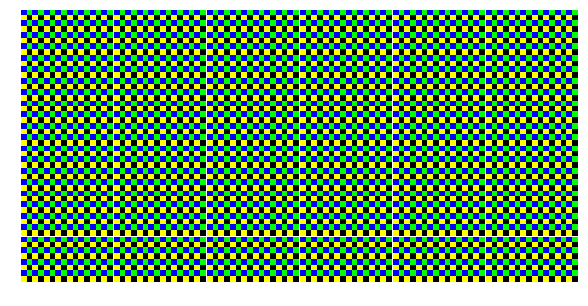

Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1592
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1647
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1701
Epoch 17/25... Discriminator Loss: 0.0000... Generator Loss: 16.1755
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.1807
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.1861
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.1915
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.1969
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2023
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2077


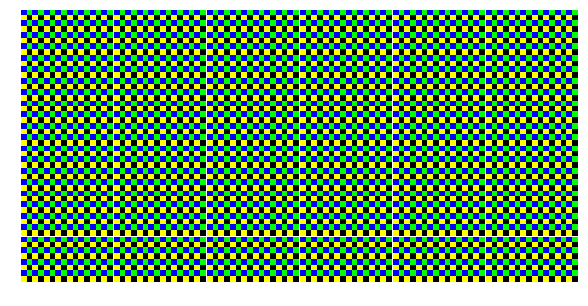

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2133
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2187
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2241
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2295
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2349
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2403
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2454
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2509
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2563
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2618


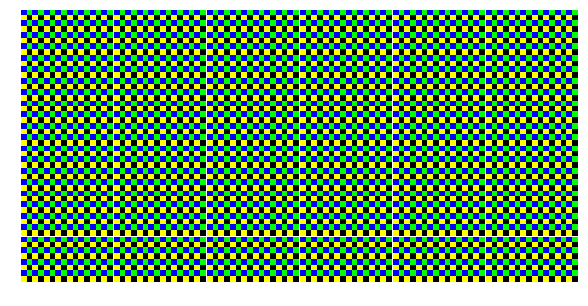

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2669
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2723
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2778
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2832
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2887
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2942
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.2994
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3048
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3102
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3156


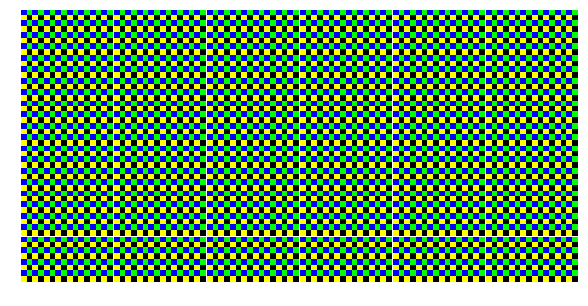

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3210
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3264
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3318
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3370
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3424
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3476
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3531
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3586
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3639
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3694


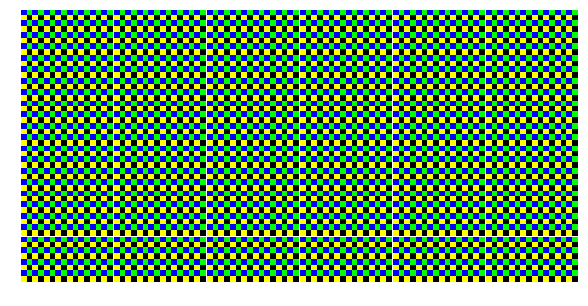

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3748
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3801
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3855
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3908
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.3962
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4017
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4070
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4125
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4180
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4235


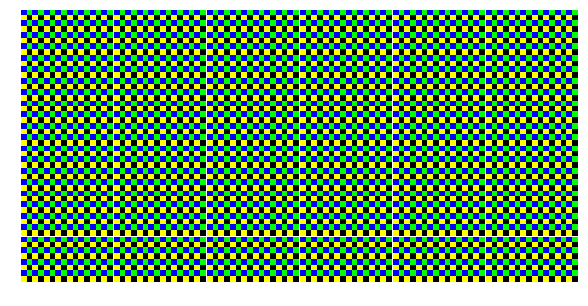

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4290
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4345
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4399
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4453
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4506
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4559
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4613
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4668
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4722
Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4777


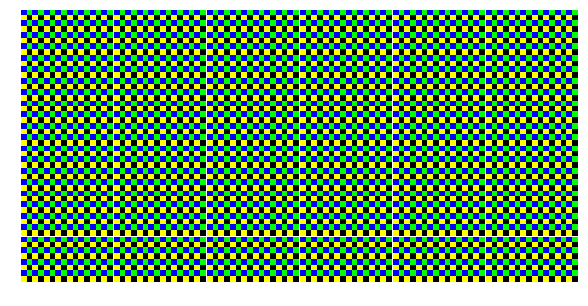

Epoch 18/25... Discriminator Loss: 0.0000... Generator Loss: 16.4830
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.4882
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.4935
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.4989
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5043
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5098
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5150
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5206
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5259
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5313


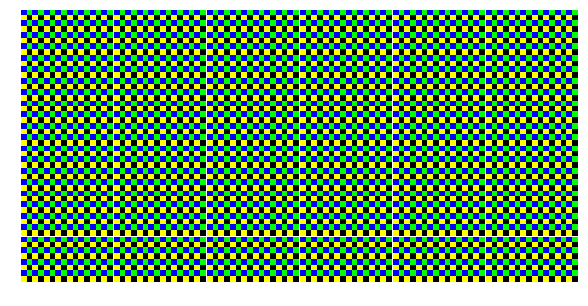

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5368
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5421
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5475
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5526
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5581
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5636
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5689
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5740
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5794
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5848


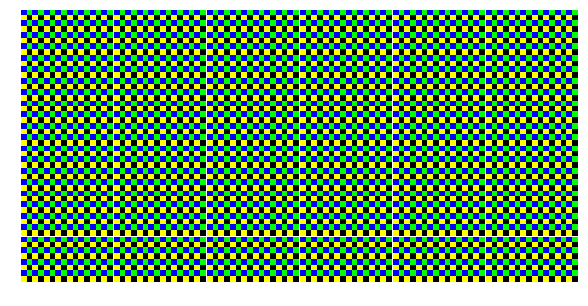

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5902
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.5957
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6011
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6065
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6118
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6171
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6226
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6279
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6333
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6386


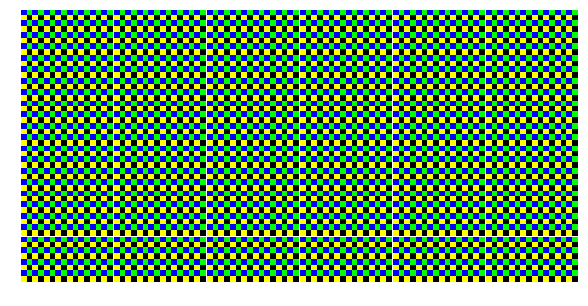

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6439
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6492
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6544
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6598
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6653
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6707
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6761
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6816
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6868
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6921


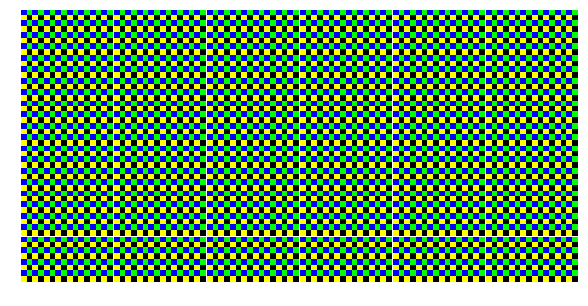

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.6975
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7029
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7083
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7136
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7190
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7246
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7300
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7354
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7409
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7463


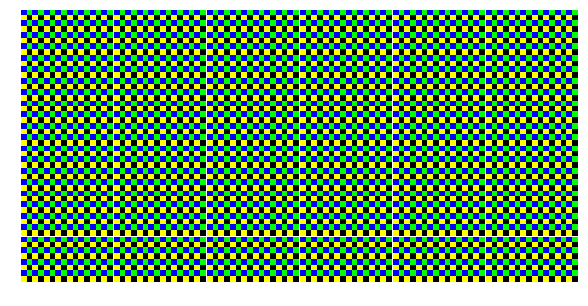

Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7516
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7570
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7615
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7677
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7731
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7785
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7840
Epoch 19/25... Discriminator Loss: 0.0000... Generator Loss: 16.7893
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.7944
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.7998


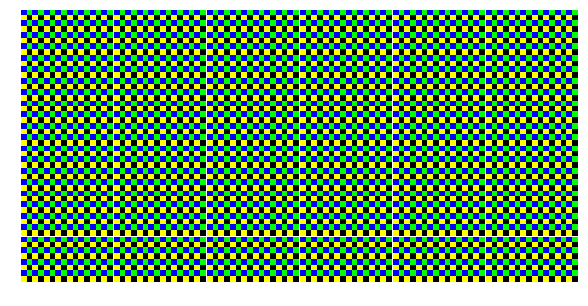

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8052
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8105
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8159
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8211
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8266
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8321
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8374
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8429
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8481
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8535


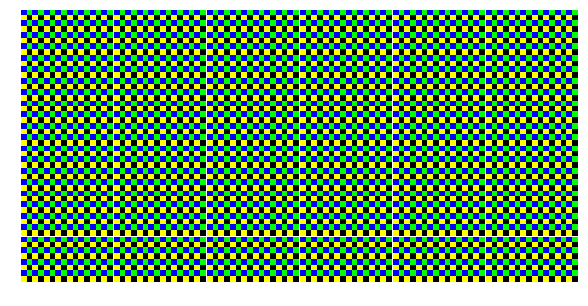

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8588
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8640
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8695
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8748
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8800
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8853
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8907
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.8961
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9015
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9070


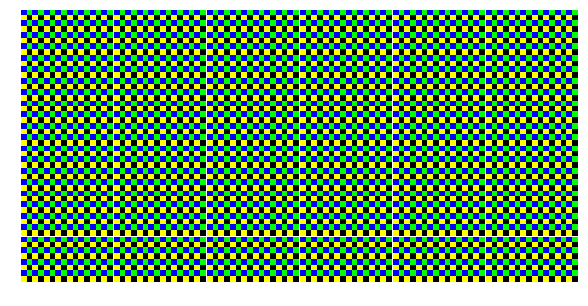

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9123
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9175
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9229
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9283
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9337
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9390
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9444
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9496
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9549
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9602


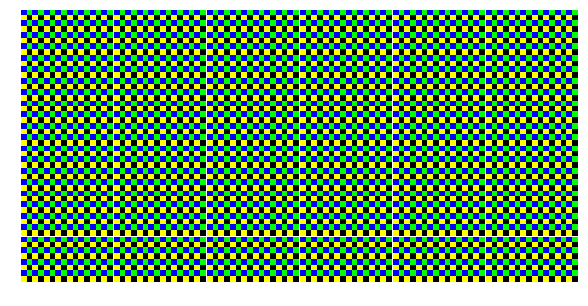

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9654
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9709
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9763
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9816
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9871
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9922
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 16.9976
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0030
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0083
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0137


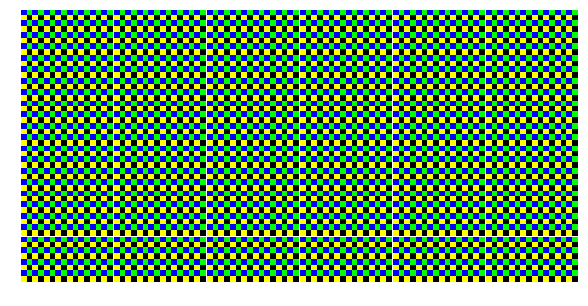

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0191
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0244
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0298
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0353
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0407
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0462
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0517
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0570
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0623
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0676


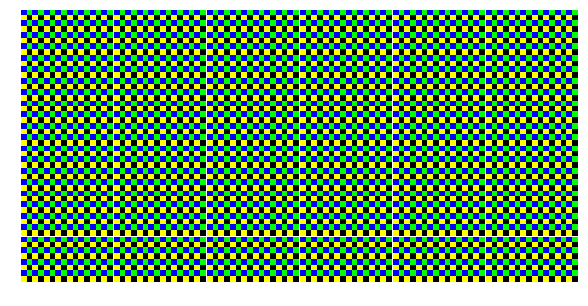

Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0729
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0783
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0837
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0892
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0945
Epoch 20/25... Discriminator Loss: 0.0000... Generator Loss: 17.0997
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1049
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1103
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1156
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1210


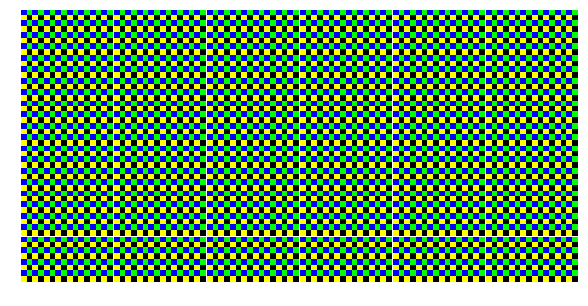

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1262
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1317
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1372
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1424
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1478
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1532
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1585
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1638
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1690
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1744


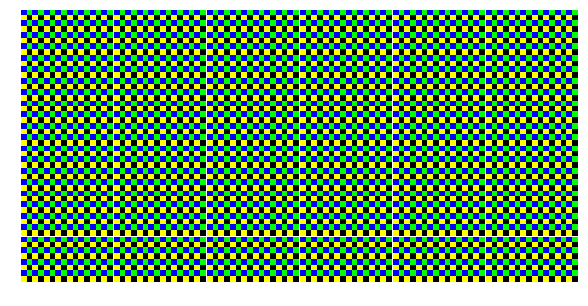

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1798
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1851
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1901
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.1955
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2009
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2063
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2117
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2172
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2224
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2277


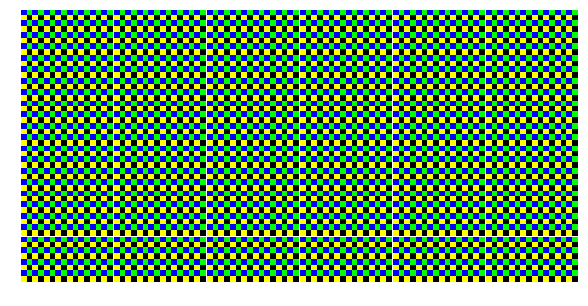

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2331
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2384
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2437
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2491
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2543
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2596
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2649
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2701
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2754
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2809


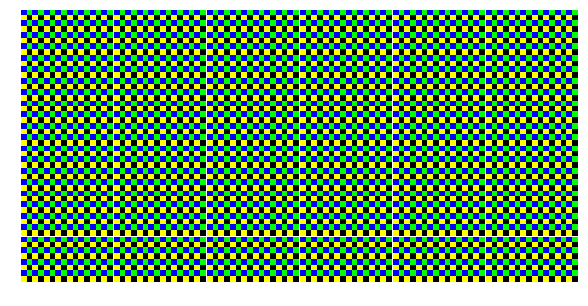

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2862
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2916
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.2969
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3021
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3075
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3128
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3182
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3235
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3289
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3343


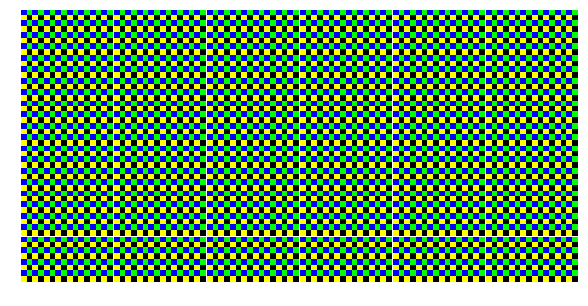

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3397
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3451
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3506
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3561
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3614
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3667
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3720
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3772
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3826
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3880


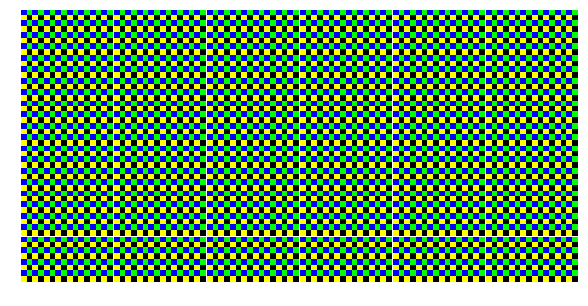

Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3934
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.3989
Epoch 21/25... Discriminator Loss: 0.0000... Generator Loss: 17.4041
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4092
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4145
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4198
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4251
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4305
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4357
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4413


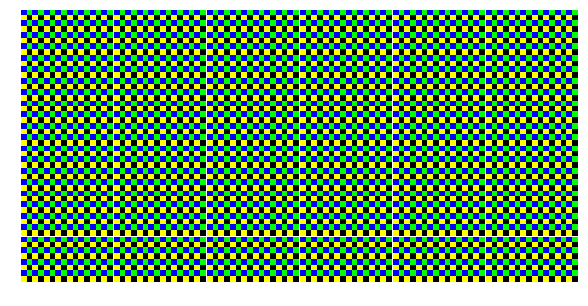

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4466
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4519
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4573
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4626
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4679
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4730
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4784
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4838
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4891
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4941


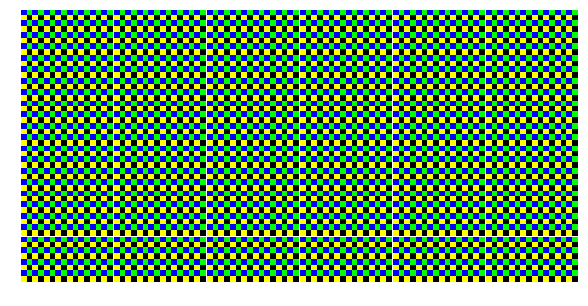

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.4995
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5049
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5102
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5157
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5211
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5263
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5316
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5369
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5422
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5476


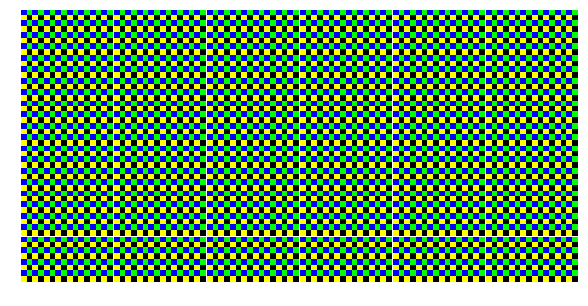

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5529
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5581
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5634
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5687
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5738
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5792
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5847
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5899
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.5953
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6007


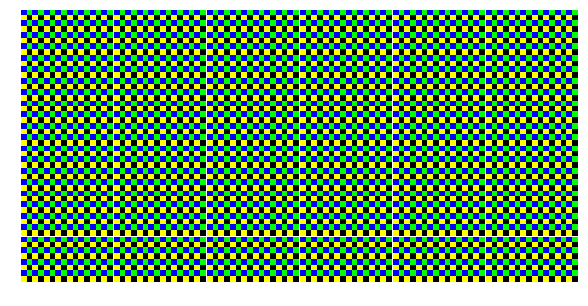

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6059
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6112
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6165
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6218
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6272
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6325
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6378
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6433
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6487
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6542


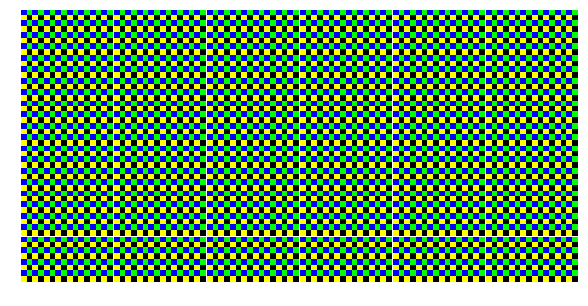

Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6596
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6649
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6702
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6755
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6809
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6861
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6915
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.6968
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.7023
Epoch 22/25... Discriminator Loss: 0.0000... Generator Loss: 17.7075


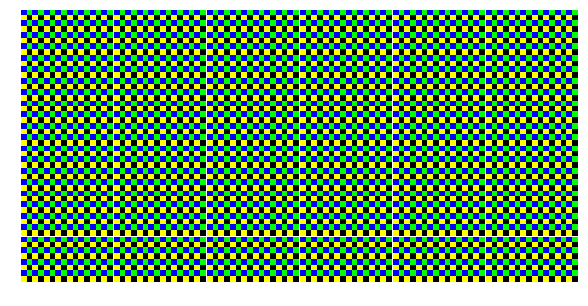

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7125
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7179
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7232
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7285
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7339
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7390
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7445
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7499
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7552
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7606


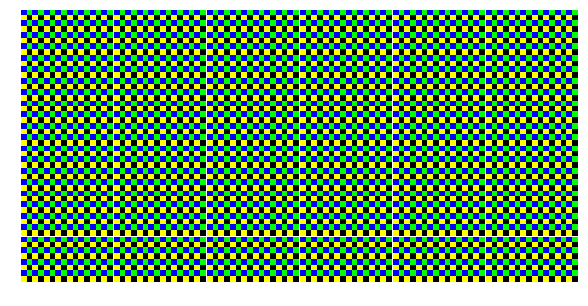

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7659
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7712
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7764
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7816
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7870
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7923
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.7974
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8027
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8080
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8134


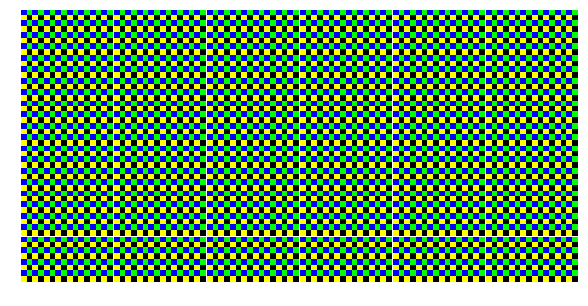

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8187
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8241
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8295
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8346
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8400
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8454
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8507
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8559
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8612
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8664


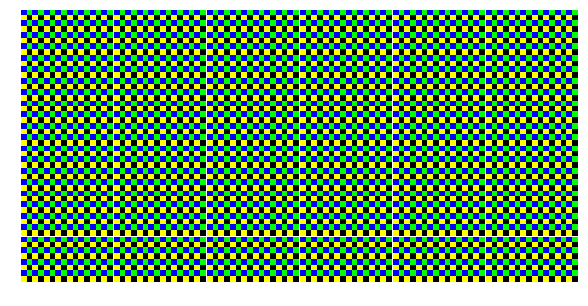

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8716
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8769
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8822
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8876
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8930
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.8982
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9036
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9088
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9140
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9194


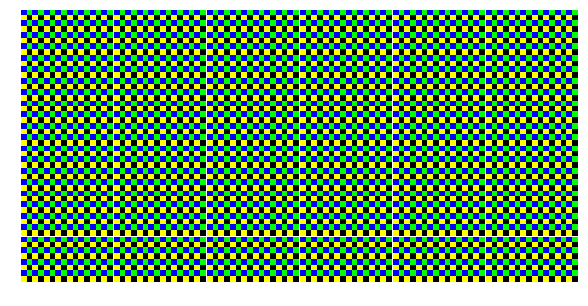

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9247
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9300
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9354
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9407
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9461
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9515
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9570
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9624
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9678
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9730


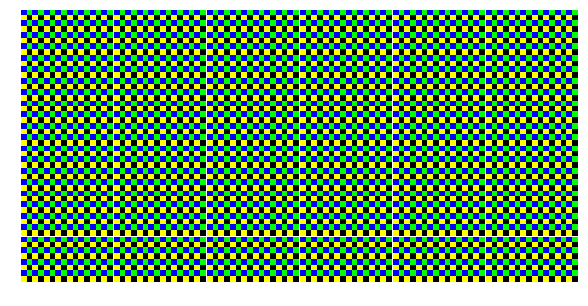

Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9784
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9837
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9888
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9942
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 17.9995
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 18.0050
Epoch 23/25... Discriminator Loss: 0.0000... Generator Loss: 18.0102
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0153
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0206
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0259


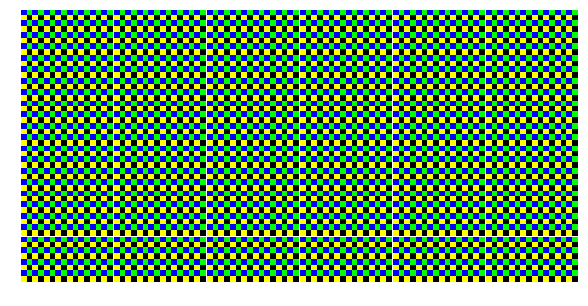

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0311
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0365
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0417
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0471
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0525
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0578
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0631
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0684
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0737
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0790


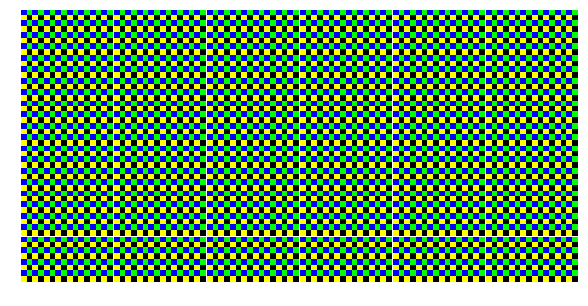

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0841
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0894
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.0948
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1001
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1051
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1104
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1158
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1212
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1265
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1319


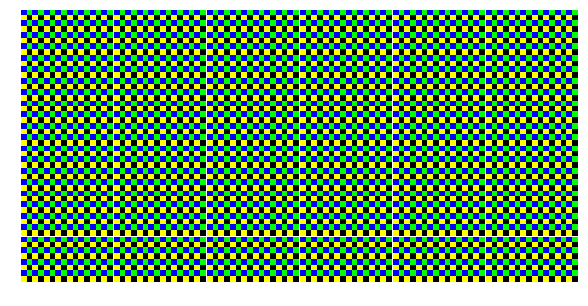

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1371
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1424
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1478
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1530
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1583
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1636
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1688
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1740
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1794
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1844


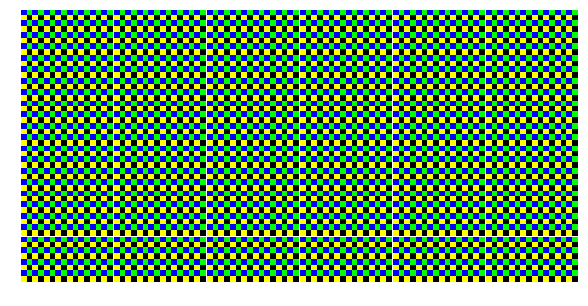

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1898
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.1952
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2005
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2059
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2111
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2163
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2216
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2269
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2323
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2376


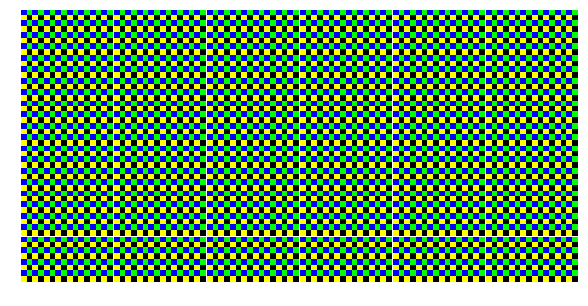

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2429
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2482
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2537
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2590
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2645
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2699
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2752
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2805
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2857
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2909


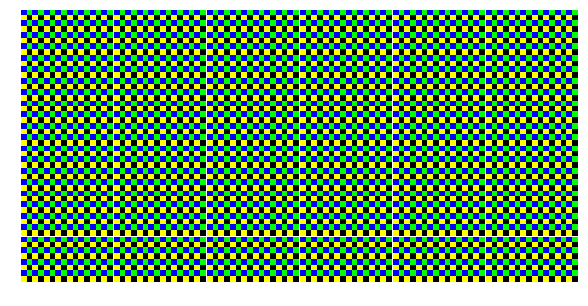

Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.2962
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.3016
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.3070
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.3125
Epoch 24/25... Discriminator Loss: 0.0000... Generator Loss: 18.3176
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3225
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3278
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3331
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3384
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3436


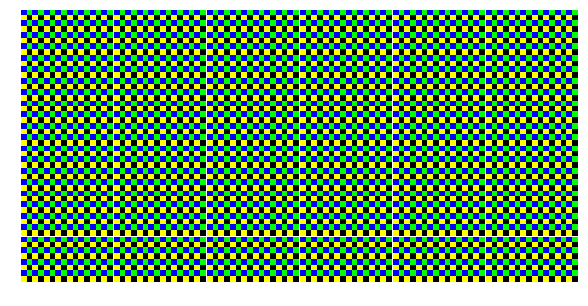

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3489
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3544
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3597
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3650
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3704
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3756
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3808
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3859
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3913
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.3967


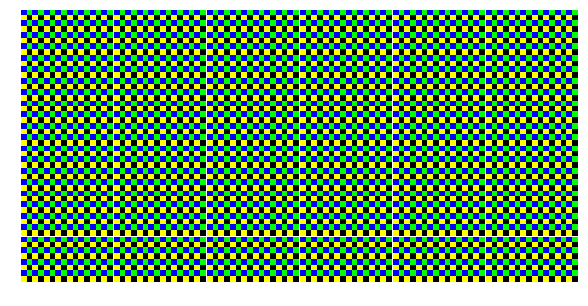

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4019
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4069
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4122
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4176
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4229
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4283
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4337
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4388
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4441
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4494


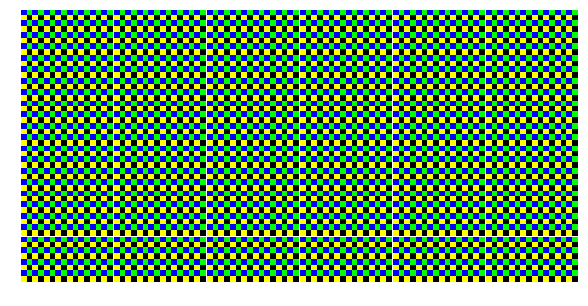

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4546
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4600
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4653
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4705
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4756
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4809
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4860
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4914
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.4968
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5020


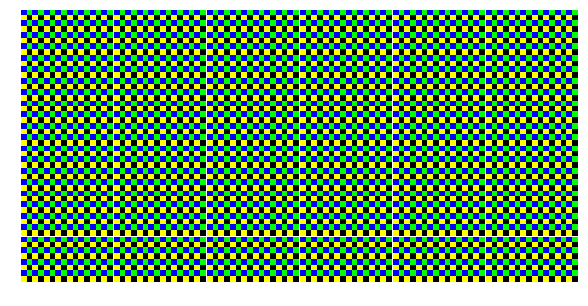

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5074
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5128
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5179
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5231
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5284
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5338
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5391
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5443
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5497
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5550


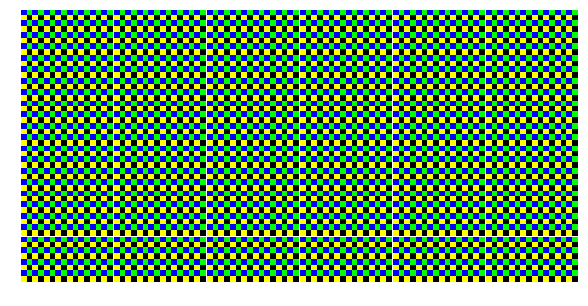

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5604
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5659
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5713
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5765
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5819
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5871
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5923
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.5975
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.6030
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.6083


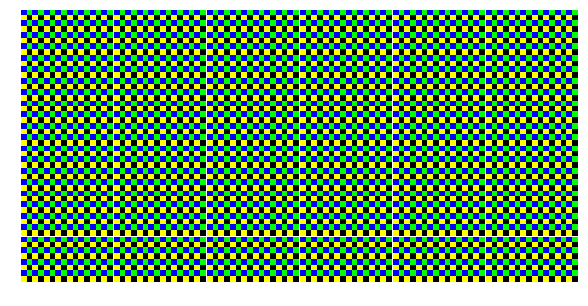

Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.6138
Epoch 25/25... Discriminator Loss: 0.0000... Generator Loss: 18.6188


In [21]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

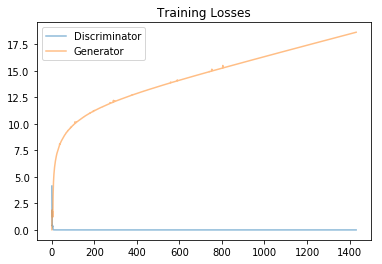

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

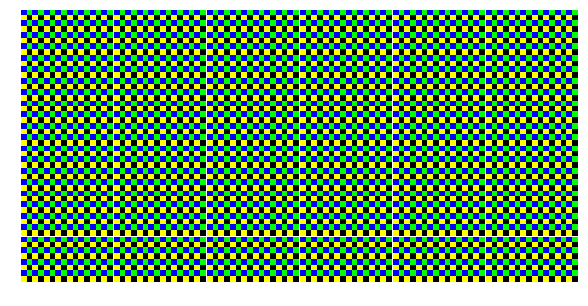

In [23]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))